# Fake News Detection <font color='ecb400'> LIAR Dataset </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# using pandas but I prefer polars instead

### <font color='AFBADC'> Preprocessing </font>

In [2]:
column_names=[
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.

        'context' # Column 14: the context (venue / location of the speech or statement).
]

# The data is already split into train, test, and validation sets.
# [REFERENCE]: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip
# We are using this for convenience and consistency
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', header=None, names=column_names)
test_data  = pd.read_csv('./liar_dataset/test.tsv',  sep='\t', header=None, names=column_names)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', header=None, names=column_names)

In [3]:
train_data.head(3)

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


<font size=5> For the initial baseline We'll start with binary classification

<font size=3.5>[PolitiFact Descriptions of labels](https://www.politifact.com/article/2018/feb/12/principles-truth-o-meter-politifacts-methodology-i/#Truth-O-Meter%20ratings)

<font size=3.5>[Binary grouping in some paper](https://aclanthology.org/W18-5513.pdf)

In [4]:
train_data['label'].value_counts()

label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

In [5]:
def binarize_labels(data: pd.DataFrame) -> pd.DataFrame:
    """Reduces 6-way classification to binary classification"""
    # We may change this if we want
    # false_labels= ['barely-true', 'false', 'pants-fire']
    true_labels= ['true', 'mostly-true', 'half-true']

    data['label'] = data['label'].apply(lambda x: 1 if x in true_labels else 0)
    
    return data

train_data = binarize_labels(train_data)
test_data  = binarize_labels(test_data)
valid_data = binarize_labels(valid_data)


In [6]:
train_data['label'].value_counts()

label
1    5752
0    4488
Name: count, dtype: int64

<font size=4> Dropping some columns as I think they are posterior knowledge that shouldn't be included in the model </font>

In [7]:
def drop_columns(data: pd.DataFrame) -> pd.DataFrame:
    """Drops columns that are not useful for training"""
    data.drop(columns=[f'count_{i+1}' for i in range(5)], inplace=True)
    return data

train_data = drop_columns(train_data)
test_data  = drop_columns(test_data)
valid_data = drop_columns(valid_data)

### Data Analysis

<font size=3.5> Missingness Check</font>

In [8]:
print(train_data.isna().sum())

id                      0
label                   0
statement               0
subjects                2
speaker                 2
speaker_job_title    2898
state_info           2210
party_affiliation       2
context               102
dtype: int64


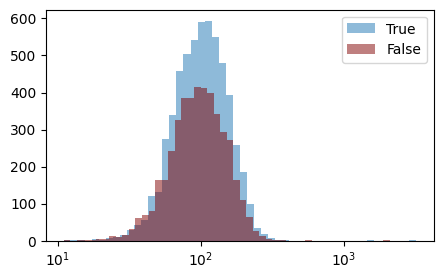

In [9]:
plt.figure(figsize=(5, 3))
plt.hist(np.log10(train_data[train_data['label']==1]['statement'].apply(lambda x: len(x)).values), bins=50,alpha=0.5)
plt.hist(np.log10(train_data[train_data['label']==0]['statement'].apply(lambda x: len(x)).values), bins=50,color='maroon',alpha=0.5)
plt.legend(['True', 'False'])
plt.xticks(np.arange(1, 4, 1), [f'$10^{i}$' for i in range(1,4)])
plt.show()

#### Meta Data Analysis

In [10]:
train_data.groupby('speaker').agg(
    true_percentage=('label', 'mean'),
    frequency=('speaker', 'count')
).sort_values(by='frequency',ascending=False).head(10)


,true_percentage,frequency
speaker,,
barack-obama,0.731557,488
donald-trump,0.263736,273
hillary-clinton,0.736402,239
mitt-romney,0.590909,176
scott-walker,0.563758,149
john-mccain,0.574324,148
rick-perry,0.521127,142
chain-email,0.119718,142
marco-rubio,0.581197,117


In [11]:
train_data.groupby('party_affiliation').agg(
    true_percentage=('label', 'mean'),
    frequency=('speaker', 'count')
).sort_values(by='frequency',ascending=False).head(10)


,true_percentage,frequency
party_affiliation,,
republican,0.501890,4497
democrat,0.662170,3336
none,0.509174,1744
organization,0.488584,219
independent,0.727891,147
newsmaker,0.660714,56
libertarian,0.675000,40
activist,0.641026,39
journalist,0.578947,38


In [12]:
train_data.groupby('state_info').agg(
    true_percentage=('label', 'mean'),
    frequency=('speaker', 'count')
).sort_values(by='frequency',ascending=False).head(10)


,true_percentage,frequency
state_info,,
Texas,0.537166,1009
Florida,0.598796,997
Wisconsin,0.509116,713
New York,0.497717,657
Illinois,0.714029,556
Ohio,0.673378,447
Georgia,0.629108,426
Virginia,0.552826,407
Rhode Island,0.582656,369


### Crude Text Preprocessing withouth using any metadata

In [28]:
from sklearn.model_selection import train_test_split

X_train, y_train = train_data['statement'], train_data['label']
X_test, y_test = test_data['statement'], test_data['label']

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)



0.6132596685082873